# Chicago's Airbnb price predictor

In [1]:
import numpy as np 
import pandas as pd
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score 

import seaborn as sns
print('Seaborn installed and imported!')

import types
from botocore.client import Config
import ibm_boto3


def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_3e09e791afe94f428292c0e35c33380c = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='DvYuffdUfODD4gaO62InDfDLlzLU58E1RcdelC96V3IR',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_3e09e791afe94f428292c0e35c33380c.get_object(Bucket='ds320project2-donotdelete-pr-kddhoh5ciaovi1',Key='Chicago_large_dataset.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

chicago = pd.read_csv(body)
chicago.head()

Seaborn installed and imported!


,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2384,https://www.airbnb.com/rooms/2384,20201220034219,2020-12-20,"Hyde Park - Walk to UChicago, 10 min to McCormick",Visiting The University of Chicago or attendin...,The apartment is less than one block from beau...,https://a0.muscache.com/pictures/acf6b3c0-47f2...,2613,https://www.airbnb.com/users/show/2613,...,10.0,10.0,10.0,R17000015609,f,1,0,1,0,2.50
1,4505,https://www.airbnb.com/rooms/4505,20201220034219,2020-12-20,394 Great Reviews. 127 y/o House. 40 yds to tr...,We have been closed for quite a while and will...,NaN,https://a0.muscache.com/pictures/10628083/3543...,5775,https://www.airbnb.com/users/show/5775,...,10.0,10.0,9.0,R19000037538,t,1,1,0,0,2.75
2,7126,https://www.airbnb.com/rooms/7126,20201220034219,2020-12-21,Tiny Studio Apartment 94 Walk Score,A very small studio in a wonderful neighborhoo...,"Ukrainian Village was just named ""Hottest Neig...",https://a0.muscache.com/pictures/51073/16c81c7...,17928,https://www.airbnb.com/users/show/17928,...,10.0,10.0,10.0,R18000034991,f,1,1,0,0,2.77
3,9811,https://www.airbnb.com/rooms/9811,20201220034219,2020-12-20,Barbara's Hideaway - Old Town,One-bedroom hideaway tucked into Old Town step...,Chicago’s Old Town neighborhood is squeezed be...,https://a0.muscache.com/pictures/37df1935-855c...,33004,https://www.airbnb.com/users/show/33004,...,9.0,10.0,9.0,2079260,f,11,11,0,0,0.65
4,10610,https://www.airbnb.com/rooms/10610,20201220034219,2020-12-20,3 Comforts of Cooperative Living,The condo is the 2nd floor in a lovely 1912 3-...,It's a 10 minute walk from the lakefront bike ...,https://a0.muscache.com/pictures/51944609/8d76...,2140,https://www.airbnb.com/users/show/2140,...,9.0,10.0,9.0,City registration pending,f,2,0,2,0,0.60


In [2]:
print(chicago.shape) #The dataset has 6523 rows and 74 columns

(6523, 74)


# Drop unnecesary columns

In [3]:
chicago.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6523 entries, 0 to 6522
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6523 non-null   int64  
 1   listing_url                                   6523 non-null   object 
 2   scrape_id                                     6523 non-null   int64  
 3   last_scraped                                  6523 non-null   object 
 4   name                                          6523 non-null   object 
 5   description                                   6503 non-null   object 
 6   neighborhood_overview                         4768 non-null   object 
 7   picture_url                                   6523 non-null   object 
 8   host_id                                       6523 non-null   int64  
 9   host_url                                      6523 non-null   o

The dataset consists of 74 columns and 6523 rows. The data types are integers, floats and objects.We can also observe that there are some missing values from 
the follwing columns(  neighborhood_overview ,description,neighborhood_overview, host_location,host_about,host_response_time,host_response_rate, host_acceptance_rate,host_neighbourhood,  neighbourhood , bathrooms_text ,  bedrooms..ect) And some columns with no values( calendar_updated, bathrooms,neighbourhood_group_cleansed ).

Let's look into the different columns and drop the ones that either the future Airbnb host would not have at the time and also the data that do not work with our regression model.

In [4]:
chicago.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [5]:
chicago=chicago.drop([# A future Airbnb member would not have currently the following information
                      'id', 'host_id', 'listing_url', 'scrape_id', 'last_scraped', 'picture_url', 'host_url',
                      'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_thumbnail_url',
                      'host_picture_url', 'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm',
                      'host_listings_count', 'host_total_listings_count', 'host_total_listings_count',
                      'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 
                      'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                      'review_scores_communication', 'review_scores_location', 'review_scores_value',
                      'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
                      'calculated_host_listings_count_private_rooms', 'license', 'reviews_per_month',
                      'calculated_host_listings_count_shared_rooms',
    
                      # We will also delete the following:
                      # Description and names
                      'name', 'description', 'neighborhood_overview', 'host_name', 'host_about', 'bathrooms_text',
                      # Columns with lists as values
                      'amenities', 'host_verifications',
                      # Columns with date values
                      'host_since', 'calendar_updated',
                      # Columns with no entries
                      'neighbourhood_group_cleansed', 'bathrooms', 'bathrooms_text', 
                     ], axis = 1)

In [6]:
# let's convert the price from string to float
chicago['price'] = chicago['price'].str.replace(',', '')
chicago['price'] = chicago['price'].str.replace('$', '')
chicago['price'] = chicago['price'].astype(float)
chicago['price'].head()

0    70.0
1    95.0
2    60.0
3    65.0
4    20.0
Name: price, dtype: float64

# Analyze categorical columns

Let's check again what is left into our database.

In [7]:
chicago.info() #The dataset that we will be using consists of  6523 rows and 29 columns.
#There are some missing values in the following columns(host_location, host_neighbourhood, neighbourhood, bedrooms,beds)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6523 entries, 0 to 6522
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_location           6514 non-null   object 
 1   host_is_superhost       6523 non-null   object 
 2   host_neighbourhood      5899 non-null   object 
 3   host_has_profile_pic    6523 non-null   object 
 4   host_identity_verified  6523 non-null   object 
 5   neighbourhood           4769 non-null   object 
 6   neighbourhood_cleansed  6523 non-null   object 
 7   latitude                6523 non-null   float64
 8   longitude               6523 non-null   float64
 9   property_type           6523 non-null   object 
 10  room_type               6523 non-null   object 
 11  accommodates            6523 non-null   int64  
 12  bedrooms                6009 non-null   float64
 13  beds                    6472 non-null   float64
 14  price                   6523 non-null   

In [8]:
chicago.describe(include='all') #Statistics summary columns. Shows that we have somemissing values. 

,host_location,host_is_superhost,host_neighbourhood,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,...,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,instant_bookable
count,6514,6523,5899,6523,6523,4769,6523,6523.000000,6523.000000,6523,...,6523.000000,6.523000e+03,6523.000000,6.523000e+03,6523,6523.000000,6523.000000,6523.000000,6523.000000,6523
unique,253,2,162,2,2,14,77,NaN,NaN,47,...,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2
top,"Chicago, Illinois, United States",f,Lakeview,t,t,"Chicago, Illinois, United States",Near North Side,NaN,NaN,Entire apartment,...,NaN,NaN,NaN,NaN,t,NaN,NaN,NaN,NaN,f
freq,4848,3969,351,6513,5245,4742,748,NaN,NaN,2860,...,NaN,NaN,NaN,NaN,6484,NaN,NaN,NaN,NaN,3953
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.898720,-87.663398,NaN,...,864.382799,3.951479e+06,31.237375,3.010749e+06,NaN,13.242833,30.304921,48.268588,160.587460,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.059047,0.042387,NaN,...,448.299089,9.203014e+07,127.115466,7.468386e+07,NaN,12.557707,25.683728,38.574773,144.319438,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.651560,-87.934340,NaN,...,1.000000,1.000000e+00,1.000000,1.000000e+00,NaN,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.873480,-87.686660,NaN,...,365.000000,9.990000e+02,2.000000,9.974000e+02,NaN,0.000000,0.000000,0.000000,0.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.901430,-87.659590,NaN,...,1125.000000,1.125000e+03,2.000000,1.125000e+03,NaN,14.000000,39.000000,64.000000,123.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.939765,-87.632985,NaN,...,1125.000000,1.125000e+03,4.000000,1.125000e+03,NaN,27.000000,57.000000,87.000000,333.000000,NaN


As it seems in the host_location columns, there is 253 different locations. However, we are only 
interested on listings that are located in Chicago, Illinois, United States. Because 
it represents 4848 entries out of 6523.

In [9]:
chicago = chicago.loc[chicago['host_location'] == 'Chicago, Illinois, United States']
# delete its column as now all its values are the same
chicago=chicago.drop(['host_location', 'neighbourhood', 'host_neighbourhood'], axis = 1)
chicago.head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,...,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,instant_bookable
0,t,t,t,Hyde Park,41.78790,-87.58780,Private room in condominium,Private room,1,1.0,...,29,29,2.0,29.0,t,0,0,0,0,f
1,t,t,t,South Lawndale,41.85495,-87.69696,Entire apartment,Entire home/apt,7,3.0,...,60,60,2.0,60.0,t,0,0,0,170,t
2,t,t,t,West Town,41.90289,-87.68182,Entire apartment,Entire home/apt,2,3.0,...,1125,1125,2.0,1125.0,t,0,0,0,0,f
3,t,t,t,Lincoln Park,41.91769,-87.63788,Entire apartment,Entire home/apt,4,1.0,...,180,180,4.0,180.0,t,7,33,33,276,f
5,t,t,t,Lincoln Park,41.91183,-87.64000,Entire apartment,Entire home/apt,4,2.0,...,180,180,4.0,180.0,t,0,0,26,83,t


# Dealing with missing values and duplicates

In [10]:
chicago.isnull().sum()  #We have 338 missing values in bedrooms and 34 in beds column.  

host_is_superhost           0
host_has_profile_pic        0
host_identity_verified      0
neighbourhood_cleansed      0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bedrooms                  338
beds                       34
price                       0
minimum_nights              0
maximum_nights              0
minimum_minimum_nights      0
maximum_minimum_nights      0
minimum_maximum_nights      0
maximum_maximum_nights      0
minimum_nights_avg_ntm      0
maximum_nights_avg_ntm      0
has_availability            0
availability_30             0
availability_60             0
availability_90             0
availability_365            0
instant_bookable            0
dtype: int64

In [11]:
# Now let's remove missing values
chicago.dropna(inplace=True)

In [12]:
#Let's fill missing values with the mean of columns
#chicago['bedrooms'] = chicago['bedrooms'].fillna(chicago['bedrooms'].mode()[0])
#chicago['beds'] = chicago['beds'].fillna(chicago['beds'].mode()[0])
chicago.isnull().sum() 

host_is_superhost         0
host_has_profile_pic      0
host_identity_verified    0
neighbourhood_cleansed    0
latitude                  0
longitude                 0
property_type             0
room_type                 0
accommodates              0
bedrooms                  0
beds                      0
price                     0
minimum_nights            0
maximum_nights            0
minimum_minimum_nights    0
maximum_minimum_nights    0
minimum_maximum_nights    0
maximum_maximum_nights    0
minimum_nights_avg_ntm    0
maximum_nights_avg_ntm    0
has_availability          0
availability_30           0
availability_60           0
availability_90           0
availability_365          0
instant_bookable          0
dtype: int64

In [13]:
chicago.shape #The data will use consists of 4481 rows and 26 columns.

(4481, 26)

In [14]:
chicago.duplicated().sum() #We have 0 doplicated rows

4

In [15]:
#Let's see the duplicated rows
dataduplicate = chicago[chicago.duplicated()] #These are all the duplicated rows, let's drop them 
dataduplicate

,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,...,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,instant_bookable
1084,f,t,t,Greater Grand Crossing,41.76769,-87.63009,Private room in townhouse,Private room,2,1.0,...,1125,1125,2.0,1125.0,t,29,59,89,89,t
1297,f,t,t,Near North Side,41.89235,-87.62732,Room in hostel,Hotel room,1,1.0,...,180,999,1.0,997.1,t,30,60,90,363,t
1372,t,t,f,Edgewater,41.99561,-87.66379,Private room in apartment,Private room,2,1.0,...,1125,1125,2.0,1125.0,t,17,47,77,352,t
3031,f,t,t,Near North Side,41.89230,-87.62734,Room in boutique hotel,Hotel room,2,1.0,...,999,1000,1.0,999.0,t,30,60,90,363,t


In [16]:
#Let's drop them
Chicago=chicago.drop_duplicates( )#let's drop all duplicates and chech data 


In [17]:
Chicago.duplicated().sum() #We have 0 doplicated rows


0

In [18]:
#Let's see data shape 
Chicago.shape  #4477 rows and 26 columns

(4477, 26)

# Prepare the data (labeling)

In [19]:
Chicago.info() #The dataset consists of 26 columns (integers, object and floats), 4477 rows and no missing values.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4477 entries, 0 to 6522
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_is_superhost       4477 non-null   object 
 1   host_has_profile_pic    4477 non-null   object 
 2   host_identity_verified  4477 non-null   object 
 3   neighbourhood_cleansed  4477 non-null   object 
 4   latitude                4477 non-null   float64
 5   longitude               4477 non-null   float64
 6   property_type           4477 non-null   object 
 7   room_type               4477 non-null   object 
 8   accommodates            4477 non-null   int64  
 9   bedrooms                4477 non-null   float64
 10  beds                    4477 non-null   float64
 11  price                   4477 non-null   float64
 12  minimum_nights          4477 non-null   int64  
 13  maximum_nights          4477 non-null   int64  
 14  minimum_minimum_nights  4477 non-null   

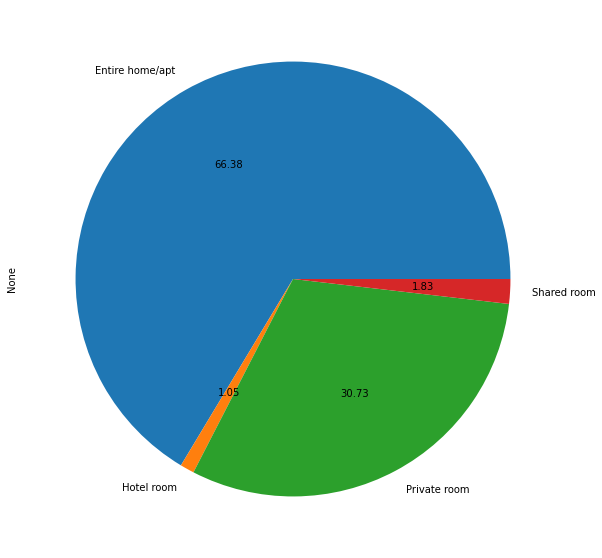

In [20]:
plt.figure(figsize=(20,10))#y is none #piechart 
Chicago.groupby('room_type').size().plot(kind='pie', autopct='%.2f')

The pie Chart in Figure 4 shows the percentage of each room type in the data set. And as observed we can see that 66.38 % Entire home, 1.83% Shared room, 1.05 % Hotel room and 30.73 % Private room.

In [21]:
# Let's dig deeper into the categorical columns

In [22]:
Chicago['host_is_superhost'].unique()

array(['t', 'f'], dtype=object)

In [23]:
Chicago['host_has_profile_pic'].unique()

array(['t', 'f'], dtype=object)

In [24]:
Chicago['host_identity_verified'].unique()

array(['t', 'f'], dtype=object)

In [25]:
Chicago['has_availability'].unique()

array(['t', 'f'], dtype=object)

In [26]:
Chicago['instant_bookable'].unique()

array(['f', 't'], dtype=object)

In [27]:
Chicago['neighbourhood_cleansed'].unique()

array(['Hyde Park', 'South Lawndale', 'West Town', 'Lincoln Park',
       'Uptown', 'Near North Side', 'North Center', 'Lake View',
       'Albany Park', 'Logan Square', 'Pullman', 'Near South Side',
       'West Ridge', 'Near West Side', 'Edgewater', 'Bridgeport',
       'Kenwood', 'Rogers Park', 'Lincoln Square', 'Grand Boulevard',
       'Forest Glen', 'Loop', 'Lower West Side', 'Humboldt Park',
       'East Garfield Park', 'North Lawndale', 'Oakland', 'Irving Park',
       'Beverly', 'Chatham', 'Mckinley Park', 'Woodlawn', 'Avondale',
       'Norwood Park', 'Portage Park', 'Washington Park', 'Morgan Park',
       'Dunning', 'West Lawn', 'South Shore', 'Armour Square',
       'South Deering', 'West Garfield Park', 'Hermosa', 'Douglas',
       'Hegewisch', 'North Park', 'Greater Grand Crossing',
       'Jefferson Park', 'Belmont Cragin', 'Garfield Ridge', 'Austin',
       'Ashburn', 'West Elsdon', 'Brighton Park', 'Archer Heights',
       'Ohare', 'Edison Park', 'Auburn Gresham', 'Ch

In [28]:
Chicago['property_type'].unique()

array(['Private room in condominium', 'Entire apartment',
       'Room in boutique hotel', 'Private room in house',
       'Private room in apartment', 'Entire condominium', 'Entire house',
       'Private room in bungalow', 'Entire loft', 'Entire townhouse',
       'Entire guest suite', 'Shared room in apartment',
       'Room in bed and breakfast', 'Private room in bed and breakfast',
       'Private room in townhouse', 'Private room in hostel',
       'Entire guesthouse', 'Private room in guest suite',
       'Shared room in hostel', 'Entire serviced apartment',
       'Entire bungalow', 'Private room in loft', 'Room in aparthotel',
       'Shared room in house', 'Room in serviced apartment',
       'Shared room in condominium', 'Private room in cottage',
       'Room in hostel', 'Entire place', 'Private room in guesthouse',
       'Private room', 'Shared room in cave', 'Shared room in bungalow',
       'Entire cottage', 'Private room in farm stay', 'Boat',
       'Entire home/apt',

In [29]:
Chicago['room_type'].unique()

array(['Private room', 'Entire home/apt', 'Shared room', 'Hotel room'],
      dtype=object)

The first 5 categorical values are True/False while the last 3 columns need labeling

In [30]:
#Converting our class label into binary value
labelencoder = LabelEncoder()
Chicago['host_is_superhost'] = labelencoder.fit_transform(Chicago['host_is_superhost'])
Chicago['host_has_profile_pic'] = labelencoder.fit_transform(Chicago['host_has_profile_pic'])
Chicago['host_identity_verified'] = labelencoder.fit_transform(Chicago['host_identity_verified'])
Chicago['has_availability'] = labelencoder.fit_transform(Chicago['has_availability'])
Chicago['instant_bookable'] = labelencoder.fit_transform(Chicago['instant_bookable'])
Chicago['neighbourhood_cleansed'] = labelencoder.fit_transform(Chicago['neighbourhood_cleansed'])
Chicago['property_type'] = labelencoder.fit_transform(Chicago['property_type'])
Chicago['room_type'] = labelencoder.fit_transform(Chicago['room_type'])

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

# Analyze correlation between columns

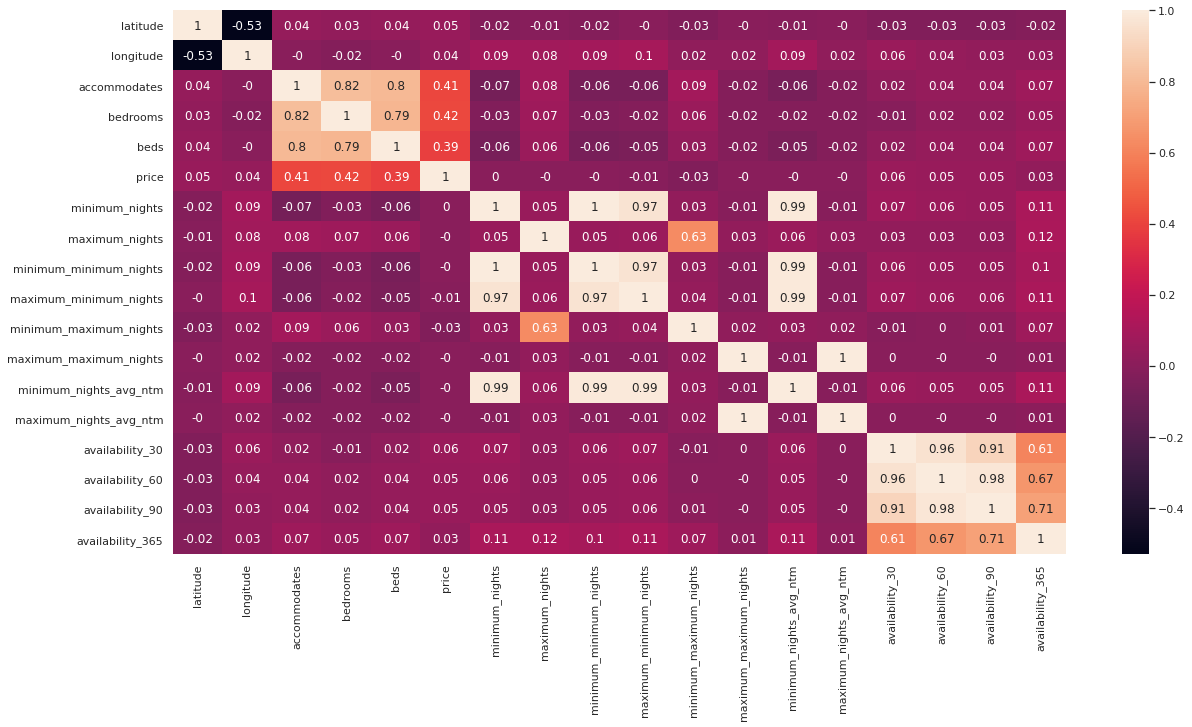

In [31]:
sns.set(rc={'figure.figsize':(20,10)})
correlation_matrix = chicago.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

To fit a linear regression model, we select those features which have a high correlation 
with our target variable price. By looking at the correlation matrix we can see that there are some variables that have 0 correclation with price.
And that beds(0.39), bedrooms (0.42)and accommodates(0.41) have the highest correlation value.
There are some multi-co-linearity between availability_30, availability_90 (0.91), minimum nights and minimum avg night(0.99), availability_30 and availability60 (0.96)
availability_60 and availability_90(0.98). And between availability_360, and avialability 30, 60 and 90. And some multi-co-linearity between minimum_nights and maximum_nights. And room_type and proprety type. The variables that have multi-co-linearity. We should not select both them together 
for training the model. 

In [32]:
# Let's now drop the columns which have 0 (Zero) correlation with price.
Chicago=Chicago.drop(['host_is_superhost', 'host_has_profile_pic', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
                      'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
                      
                     ], axis = 1)

In [33]:
# We also have to drop columns that have high correlation between them. 
Chicago=Chicago.drop(['property_type', 'availability_60', 'availability_90', 'availability_365'
                     ], axis = 1)

In [34]:
Chicago.shape #Data have 4477 rows and 14 columns

(4477, 14)

In [35]:
Chicago.info() #Data have 14 columns and 4477 rows.There are no missing values and data type are integers and floats.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4477 entries, 0 to 6522
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_identity_verified  4477 non-null   int64  
 1   neighbourhood_cleansed  4477 non-null   int64  
 2   latitude                4477 non-null   float64
 3   longitude               4477 non-null   float64
 4   room_type               4477 non-null   int64  
 5   accommodates            4477 non-null   int64  
 6   bedrooms                4477 non-null   float64
 7   beds                    4477 non-null   float64
 8   price                   4477 non-null   float64
 9   maximum_minimum_nights  4477 non-null   int64  
 10  minimum_maximum_nights  4477 non-null   int64  
 11  has_availability        4477 non-null   int64  
 12  availability_30         4477 non-null   int64  
 13  instant_bookable        4477 non-null   int64  
dtypes: float64(5), int64(9)
memory usage: 52

# Remove outliers

[4452   17    6    1    0    0    0    0    0    1]
[  10.  1008.9 2007.8 3006.7 4005.6 5004.5 6003.4 7002.3 8001.2 9000.1
 9999. ]


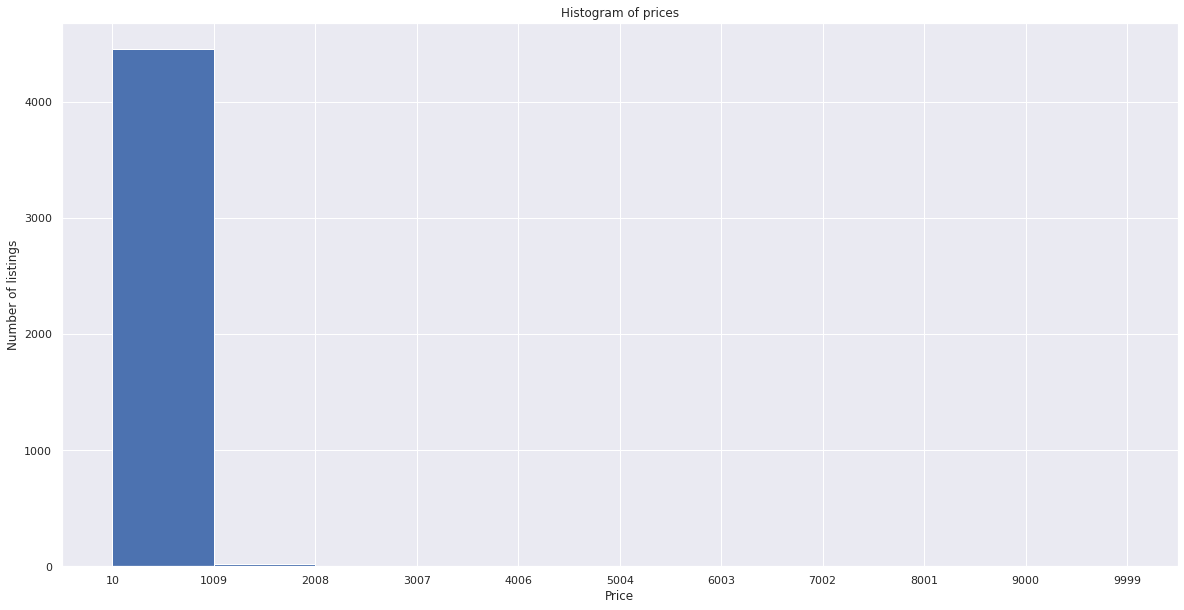

In [36]:
# Histogram
# set bin edges
count, bin_edges = np.histogram(Chicago['price'])
print(count) # frequency count
print(bin_edges) # bin ranges, default = 10 bins

#Create the histogram
chicago['price'].plot(kind='hist', figsize=(20, 10), xticks=bin_edges)

plt.title('Histogram of prices') # add a title to the histogram
plt.ylabel('Number of listings') # add y-label
plt.xlabel('Price') # add x-label

plt.show()

In [37]:
# Of course rooms that cost more than couple of 100s per night would be outliers and should be removed

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8a8c8866d0>,
      dtype=object)

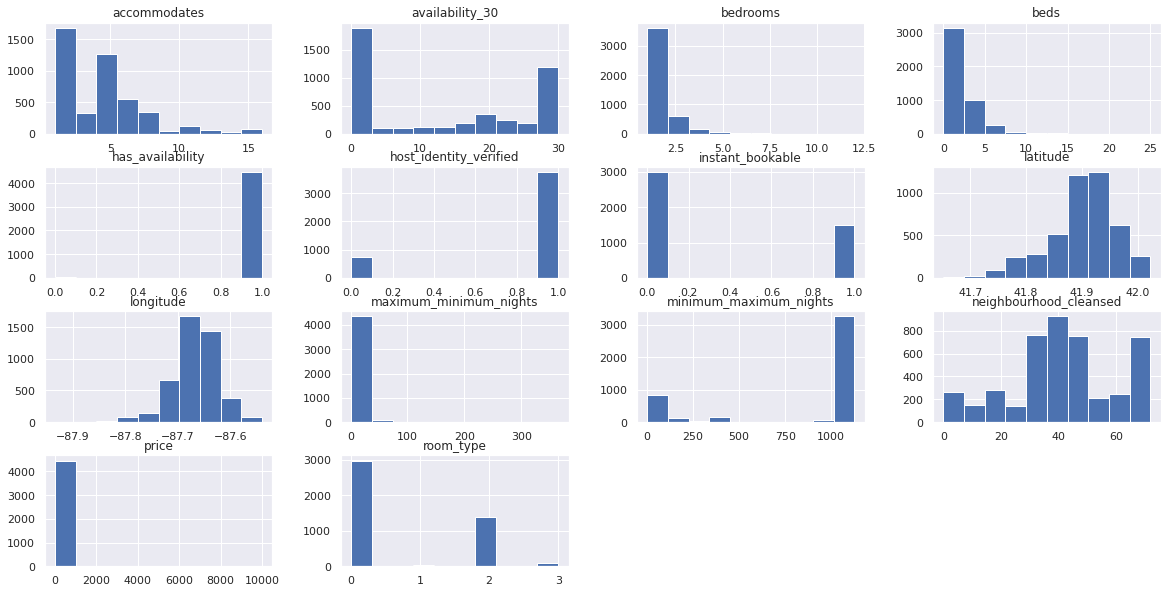

In [38]:
Chicago.hist()

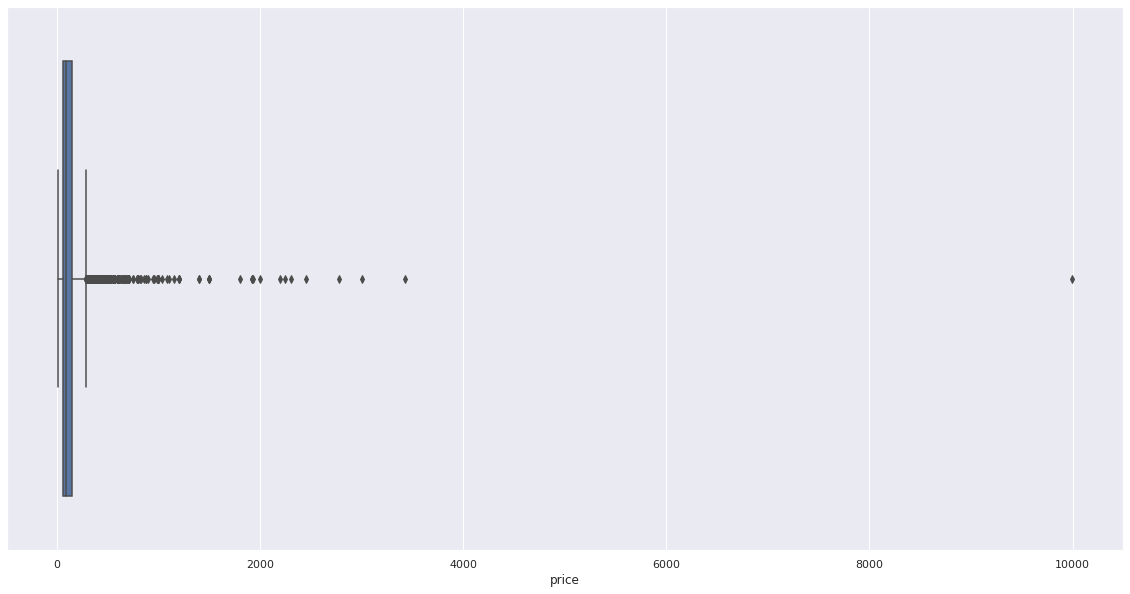

In [39]:
sns.boxplot(x=Chicago['price'])

The box plot is a visualization of price, and the data have a right-skewed distribution with some outliers. We will do some outliers detection and see if these outliers will affect our data analysis. 

In [40]:
#Let's check outliers. We will calculate Z score to find the values  above the mean value of Age
z_score = np.abs(stats.zscore(Chicago))
print(z_score)

[[0.44391308 0.57602812 1.87626586 ... 0.06353566 1.03691427 0.70485729]
 [0.44391308 1.03248652 0.76634003 ... 0.06353566 1.03691427 1.4187269 ]
 [0.44391308 1.56865807 0.02724453 ... 0.06353566 1.03691427 0.70485729]
 ...
 [0.44391308 0.62964528 0.04611575 ... 0.06353566 0.39526969 0.70485729]
 [0.44391308 1.62227522 1.940275   ... 0.06353566 1.350059   0.70485729]
 [0.44391308 1.08610367 2.40169795 ... 0.06353566 0.87266434 0.70485729]]


In [41]:
# The points we have from Z we can't tell which points are outliers. Therefore we set a cutoff of Z>2
threshold = 2
print(np.where(z_score > 2))

(array([   6,   11,   12, ..., 4473, 4473, 4476]), array([9, 0, 7, ..., 0, 8, 2]))


In [42]:
Chicago_nout= Chicago[(z_score< 2).all(axis=1)] 
print(Chicago_nout.shape) # We can see that our intial data was 4477 now fter droping the outliers is 2861(1616 rows less(36 % of the data)).

(2861, 14)


In [43]:
#Let's check outliers. We will calculate Z score to find the values  above the mean value of Age

z_score = np.abs(stats.zscore(Chicago))
print(z_score)

[[0.44391308 0.57602812 1.87626586 ... 0.06353566 1.03691427 0.70485729]
 [0.44391308 1.03248652 0.76634003 ... 0.06353566 1.03691427 1.4187269 ]
 [0.44391308 1.56865807 0.02724453 ... 0.06353566 1.03691427 0.70485729]
 ...
 [0.44391308 0.62964528 0.04611575 ... 0.06353566 0.39526969 0.70485729]
 [0.44391308 1.62227522 1.940275   ... 0.06353566 1.350059   0.70485729]
 [0.44391308 1.08610367 2.40169795 ... 0.06353566 0.87266434 0.70485729]]


In [44]:
# The points we have from Z we can't tell which points are outliers. Therefore we set a cutoff of Z>3
threshold = 3
print(np.where(z_score > 3))

(array([   6,   12,   25,   26,   27,   29,   33,   33,   33,   33,   35,
         73,   74,   80,  108,  108,  113,  122,  124,  125,  125,  133,
        140,  159,  170,  173,  190,  196,  196,  196,  196,  199,  201,
        203,  204,  208,  229,  229,  229,  229,  311,  328,  330,  372,
        388,  403,  516,  526,  526,  533,  632,  640,  693,  693,  747,
        758,  763,  802,  804,  811,  812,  812,  831,  834,  870,  874,
        874,  902,  913,  913,  914,  914,  933,  947,  947,  947,  947,
        983,  990, 1049, 1050, 1065, 1072, 1072, 1072, 1072, 1109, 1121,
       1137, 1162, 1186, 1186, 1186, 1186, 1200, 1200, 1200, 1205, 1255,
       1256, 1262, 1263, 1269, 1269, 1282, 1290, 1306, 1306, 1324, 1326,
       1336, 1338, 1338, 1350, 1359, 1396, 1401, 1434, 1447, 1454, 1454,
       1454, 1471, 1471, 1471, 1473, 1473, 1473, 1476, 1531, 1560, 1561,
       1569, 1581, 1584, 1609, 1615, 1616, 1622, 1622, 1622, 1628, 1635,
       1635, 1635, 1642, 1654, 1683, 1705, 1724, 1

In [45]:
outdata1=Chicago[(z_score >=3)]# Now we are creating a data frame of all the values that are bigger than 3(outliers)
#The mean of the outliers
outdata1.mean()

host_identity_verified      0.888372
neighbourhood_cleansed     41.693023
latitude                   41.898855
longitude                 -87.674471
room_type                   0.260465
accommodates               10.602326
bedrooms                    4.051163
beds                        6.581395
price                     618.062791
maximum_minimum_nights     21.286047
minimum_maximum_nights    866.462791
has_availability            0.953488
availability_30            14.946512
instant_bookable            0.302326
dtype: float64

In [46]:
Chicago_nout1= Chicago[(z_score< 3).all(axis=1)] 
print(Chicago_nout1.shape) # We can see that our intial data was 4477 now fter droping the outliers is 4179(298 rows less, 6.7% ).

(4179, 14)


In [47]:
Chicago.mean() #The mean of data columns with the outliers

host_identity_verified      0.835381
neighbourhood_cleansed     41.743355
latitude                   41.901244
longitude                 -87.667195
room_type                   0.680143
accommodates                4.253965
bedrooms                    1.753630
beds                        2.198794
price                     136.719678
maximum_minimum_nights      8.215546
minimum_maximum_nights    858.447398
has_availability            0.995979
availability_30            13.032164
instant_bookable            0.331919
dtype: float64

In [48]:
Chicago_nout1.mean() #The mean of data column with out the outliers

host_identity_verified      0.834171
neighbourhood_cleansed     41.758794
latitude                   41.901756
longitude                 -87.666389
room_type                   0.702321
accommodates                3.931802
bedrooms                    1.640584
beds                        1.991146
price                     114.174444
maximum_minimum_nights      6.814549
minimum_maximum_nights    858.309404
has_availability            1.000000
availability_30            12.904762
instant_bookable            0.334051
dtype: float64

As you can see the dataset with outliers have a higher mean of price (136.719678) than without outliers (114.174444).From this we can see that having the outliers will effect our analysis.There

In [49]:
Chicago_nout1.info() #This is the clean data with 4179 rows and 14 columns.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4179 entries, 0 to 6522
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_identity_verified  4179 non-null   int64  
 1   neighbourhood_cleansed  4179 non-null   int64  
 2   latitude                4179 non-null   float64
 3   longitude               4179 non-null   float64
 4   room_type               4179 non-null   int64  
 5   accommodates            4179 non-null   int64  
 6   bedrooms                4179 non-null   float64
 7   beds                    4179 non-null   float64
 8   price                   4179 non-null   float64
 9   maximum_minimum_nights  4179 non-null   int64  
 10  minimum_maximum_nights  4179 non-null   int64  
 11  has_availability        4179 non-null   int64  
 12  availability_30         4179 non-null   int64  
 13  instant_bookable        4179 non-null   int64  
dtypes: float64(5), int64(9)
memory usage: 48

# Split data into dependent and independent variables

In [50]:
# Let's import all the modules we need
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression #For linear regression implementation
from sklearn.metrics import mean_squared_error #Its for model evaluation
from sklearn.metrics import r2_score #Its for model evaluation

#Dataframe with multiple columns/attributes
X = Chicago_nout1.drop(columns=['price'], inplace=False)
Y = Chicago_nout1['price']
X.head()

,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,maximum_minimum_nights,minimum_maximum_nights,has_availability,availability_30,instant_bookable
0,1,31,41.78790,-87.58780,2,1,1.0,1.0,2,29,1,0,0
1,1,61,41.85495,-87.69696,0,7,3.0,5.0,2,60,1,0,1
2,1,71,41.90289,-87.68182,0,2,3.0,4.0,2,1125,1,0,0
3,1,36,41.91769,-87.63788,0,4,1.0,2.0,4,180,1,7,0
5,1,36,41.91183,-87.64000,0,4,2.0,2.0,4,180,1,0,1


# Sampling

In [51]:
#Smapling
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(3343, 13)
(836, 13)
(3343,)
(836,)


# Multilineal Regression

### Model building

In [52]:
lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

LinearRegression()

### Model evaluation for training set

In [53]:
# model evaluation for training set (multilinear regression)


y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

The model performance for training set
--------------------------------------
RMSE is 74.0172067814578
R2 score is 0.3534992503956573




### Model evaluation for testing set

In [54]:
# model evaluation for testing set(multilinear regression)
y_test_predict = lin_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for testing set
--------------------------------------
RMSE is 86.90434127110497
R2 score is 0.29491414392517457


The R-square in training set is 0.35l, which reveals that only 35 % of the data fit the regression model, and 0.29 in the testing set. Therefore, we will  do a polynomial regression model to see if the R-square value improves.

# Polynomial Regression

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [56]:
#Creating training and Testing sampling
msk = np.random.rand(len(Chicago_nout1)) < 0.8
train = Chicago_nout1[msk]
test = Chicago_nout1[~msk]
train_x = Chicago_nout1.drop(columns=['price'], inplace=False)
train_y = Chicago_nout1['price']
X.head()

,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,maximum_minimum_nights,minimum_maximum_nights,has_availability,availability_30,instant_bookable
0,1,31,41.78790,-87.58780,2,1,1.0,1.0,2,29,1,0,0
1,1,61,41.85495,-87.69696,0,7,3.0,5.0,2,60,1,0,1
2,1,71,41.90289,-87.68182,0,2,3.0,4.0,2,1125,1,0,0
3,1,36,41.91769,-87.63788,0,4,1.0,2.0,4,180,1,7,0
5,1,36,41.91183,-87.64000,0,4,2.0,2.0,4,180,1,0,1


In [57]:
poly = PolynomialFeatures(degree= 4)
poly_features = poly.fit_transform(X_train)
poly.fit(X_train,Y_train)
poly_regression = LinearRegression()
poly_regression.fit(poly_features,Y_train)

y_train_predict = poly_regression.predict(poly_features)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)
print("The model performance for training set")
print("--------------------------------------")
print('R2 score is {}'.format(r2))
print("\n")


The model performance for training set
--------------------------------------
R2 score is 0.7459674430643368




In [58]:
poly = PolynomialFeatures(degree= 4)
poly_features = poly.fit_transform(X_test)
poly.fit(X_test,Y_test)
poly_regression = LinearRegression()
poly_regression.fit(poly_features,Y_test)

y_test_predict = poly_regression.predict(poly_features)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)
print("The model performance for training set")
print("--------------------------------------")
print('R2 score is {}'.format(r2))
print("\n")


The model performance for training set
--------------------------------------
R2 score is 0.9999986414144557




The polynomial model with degree= four training set has an R-square value of 0.75, and the testing set has an R-square value of 0.99. This model's R-square results are better than the multilinear regression model
suggesting that the problem is non-linear. We will try to change the value of degreed to 6 and see if the R-square value improves. 

In [59]:
poly = PolynomialFeatures(degree= 6)
poly_features = poly.fit_transform(X_train)
poly.fit(X_train,Y_train)
poly_regression = LinearRegression()
poly_regression.fit(poly_features,Y_train)

y_train_predict = poly_regression.predict(poly_features)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)
print("The model performance for training set")
print("--------------------------------------")
print('R2 score is {}'.format(r2))
print("\n")


The model performance for training set
--------------------------------------
R2 score is 0.8820391409328682




In [60]:
poly = PolynomialFeatures(degree= 6)
poly_features = poly.fit_transform(X_test)
poly.fit(X_test,Y_test)
poly_regression = LinearRegression()
poly_regression.fit(poly_features,Y_test)

y_test_predict = poly_regression.predict(poly_features)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)
print("The model performance for training set")
print("--------------------------------------")
print('R2 score is {}'.format(r2))
print("\n")


The model performance for training set
--------------------------------------
R2 score is 0.99999995309006




The Polynomial model with degree = six has an R-square of 0.88 in the training set and an R-square of 0.99 in the testing set. R-square results in this model are better than the Polynomial model with degree=4.

Conclusion:
The model with the highest R-squared value was polynomial regression with degree = 6. 
Airbnb's characteristics explain 88% of the total variation in the Airbnb price.
